In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from scipy.stats import mode
import gc  # Import the garbage collection module
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
import keras

def sort_cmp (key):
    ans = 0
    for c in key:
        if (c.isdigit() == True):
            ans = ans * 10 + int (c)
    return ans

def load_test_data(dir_rec, save=False):
    x, y = [], [] 
    print (dir_rec)
    for file in sorted(glob.glob(dir_rec + "/*.wav")):
        # load an audio file as a floating point time series.    
        data, sr = librosa.load(file)
        #print ('shape:', data.shape, ' ', sr)
        # extract features from audio files into numpy array
        #feature = extract_feature(data, sr, mfcc=True/*, chroma=True, mel=True)
        seg = np.array (divide_into_segments (data, sr))
        i = 0
        for s in seg:
            feature = extract_feature(s, sr, mfcc=True, chroma=True, mel=True)
            x.append(feature)
            #x_orig.append (s)
            i+= 1
            if (i == 5):
                break
        file_name = os.path.basename(file)
        #print (file_name)
        if (file_name.count ('Neutral') > 0):
            emotion = file_name.split ('.')[0].split ('_')[4]
        else:
            emotion = file_name.split ('.')[0].split ('_')[4]
        
        if (emotion == 'Calmness'):
            emotion = 'Calmness'    
        # get emotion label from the file name
        i = 0
        for s in seg:
            y.append(emotions.index (emotion))
            i += 1
            if (i == 5):
                break
    
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)
        
    return np.array(x), y
def divide_into_segments (data, sr, seg_dur_seconds = 5):
    segment_length = sr * seg_dur_seconds
    num_sections = int(np.floor(len(data) / segment_length))
    split = []
    for i in range(num_sections):
        t = data[i * segment_length: (i + 1) * segment_length]
        split.append(t)
    return split 

def extract_feature(data, sr, mfcc, chroma, mel):
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
        
    if mel:           
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

def proc_data (file, emotion):
    x = []
    y = []
    data, sr = librosa.load(file)
    seg = np.array (divide_into_segments (data, sr))
    i = 0
    for s in seg:
        feature = extract_feature(s, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        i+= 1
        if (i == 5):
            break
    i = 0
    for s in seg:
        y.append(emotions.index (emotion))
        i += 1
        if (i == 5):
            break
    return x, y

def extract_index_video(filename):
    key = (int (filename.split ('/')[-1].split('_')[1]), int (filename.split ('/')[-1].split('_')[5]))
    return key

def extract_index_audio(filename):
    if (filename.count ('neutral') > 0):
        return (int (filename.split ('/')[-1].split('_')[1]), 0)
    
    key = (int (filename.split ('/')[-1].split('_')[1]), int (filename.split ('/')[-1].split('_')[3]))
    
    return key

2025-04-04 23:27:59.153976: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 23:27:59.185265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 23:27:59.185301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 23:27:59.186335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 23:27:59.191577: I tensorflow/core/platform/cpu_feature_guar

# 50-50 split

In [1]:
acc = []
fscore = []
confusion = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 40])
            y_train.extend (labels [i*80: i*80 + 40])
            x_test.extend (data [i*80 + 40: i*80 + 80])
            y_test.extend (labels [i*80 + 40: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
         
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        audio_model = Sequential()
        audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        audio_model.add(Activation('relu'))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        audio_model.add(Activation('relu'))
        audio_model.add(Dropout(0.1))
        audio_model.add(MaxPooling1D(pool_size=(8)))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        audio_model.add(Activation('relu'))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        audio_model.add(Activation('relu'))
        audio_model.add(Dropout(0.5))
        audio_model.add(Flatten())
        audio_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        audio_model.add(Activation('softmax'))
        audio_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        audio_model.fit(x_train, train_labels_one_hot, validation_data=(x_test, test_labels_one_hot), epochs=100, batch_size=64, verbose = False)
        loss, accuracy = audio_model.evaluate(x_test, test_labels_one_hot)
        y_pred = audio_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)

2025-04-02 11:50:44.867305: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 11:50:45.175218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 11:50:45.175308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 11:50:45.231063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 11:50:45.340811: I tensorflow/core/platform/cpu_feature_guar

GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio


2025-04-02 11:51:19.492002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43516 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:47:00.0, compute capability: 8.9
2025-04-02 11:51:20.757639: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-02 11:51:20.893193: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-02 11:51:21.209136: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-02 11:51:22.025840: I external/local_xla/xla/service/service.cc:168] XLA service 0x145ae4f1c470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 11:51:22.025876: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


7/7 [==============================] - 0s 868us/step
Audio Accuracy for subject1 : 43.00%
F1:  0.40903127383676585
Confusion: [[35  1  1  1  2]
 [10  8 10  5  7]
 [21  1 11  1  6]
 [ 2  5  7 18  8]
 [25  0  0  1 14]]
subject2
/opt/scratchspace/mbibars/eeg/data/EAV/subject2/Audio
7/7 [==============================] - 0s 816us/step
Audio Accuracy for subject2 : 72.00%
F1:  0.7186160642849688
Confusion: [[29  4  4  0  3]
 [ 1 35  0  4  0]
 [ 3  2 26  9  0]
 [ 4  8  6 22  0]
 [ 8  0  0  0 32]]
subject3
/opt/scratchspace/mbibars/eeg/data/EAV/subject3/Audio
7/7 [==============================] - 0s 853us/step
Audio Accuracy for subject3 : 45.00%
F1:  0.43105816185384355
Confusion: [[18  1  3  0 18]
 [ 1 11  6  8 14]
 [ 1  8 24  1  6]
 [ 1 20  2  5 12]
 [ 4  2  2  0 32]]
subject4
/opt/scratchspace/mbibars/eeg/data/EAV/subject4/Audio
7/7 [==============================] - 0s 798us/step
Audio Accuracy for subject4 : 65.50%
F1:  0.6542335687135238
Confusion: [[22  1  0  0 17]
 [ 0 36  4  0  0]


In [8]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.528690476502691
Mean F1score across patients: 0.5176819166892974
Total Confusion Matrix: 
[[1000   36  101   16  527]
 [  36  922  302  203  217]
 [  73  302  887  240  178]
 [  32  524  353  606  165]
 [ 329  107  164   54 1026]]


In [9]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

In [1]:
confusion = [[1000,   36,  101,   16,  527],
 [  36,  922,  302,  203,  217],
 [  73,  302,  887 , 240,  178],
 [  32 , 524 , 353 , 606 , 165],
 [ 329 , 107,  164 ,  54, 1026]]

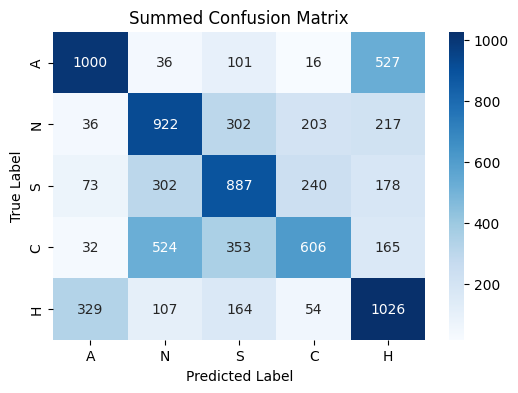

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

In [6]:
root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 40])
            y_train.extend (labels [i*80: i*80 + 40])
            x_test.extend (data [i*80 + 40: i*80 + 80])
            y_test.extend (labels [i*80 + 40: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : {x_train.shape, x_test.shape}")

GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : ((200, 180, 1), (200, 180, 1))
subject2
/opt/scratchspace/mbibars/eeg/data/EAV/subject2/Audio
Shapes for subject2 : ((200, 180, 1), (200, 180, 1))
subject3
/opt/scratchspace/mbibars/eeg/data/EAV/subject3/Audio
Shapes for subject3 : ((200, 180, 1), (200, 180, 1))
subject4
/opt/scratchspace/mbibars/eeg/data/EAV/subject4/Audio
Shapes for subject4 : ((200, 180, 1), (200, 180, 1))
subject5
/opt/scratchspace/mbibars/eeg/data/EAV/subject5/Audio
Shapes for subject5 : ((200, 180, 1), (200, 180, 1))
subject6
/opt/scratchspace/mbibars/eeg/data/EAV/subject6/Audio
Shapes for subject6 : ((200, 180, 1), (200, 180, 1))
subject7
/opt/scratchspace/mbibars/eeg/data/EAV/subject7/Audio
Shapes for subject7 : ((200, 180, 1), (200, 180, 1))
subject8
/opt/scratchspace/mbibars/eeg/data/EAV/subject8/Audio
Shapes for subject8 : ((200, 180, 1), (200, 180, 1))
subject9
/opt/scratchspace/mbibars/eeg/data/EAV/subject9/Au

# 70-30 split

In [7]:
acc = []
fscore = []
confusion = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 56])
            y_train.extend (labels [i*80: i*80 + 56])
            x_test.extend (data [i*80 + 56: i*80 + 80])
            y_test.extend (labels [i*80 + 56: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{ x_test.shape}")
         
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        audio_model = Sequential()
        audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        audio_model.add(Activation('relu'))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        audio_model.add(Activation('relu'))
        audio_model.add(Dropout(0.1))
        audio_model.add(MaxPooling1D(pool_size=(8)))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        audio_model.add(Activation('relu'))
        audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        audio_model.add(Activation('relu'))
        audio_model.add(Dropout(0.5))
        audio_model.add(Flatten())
        audio_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        audio_model.add(Activation('softmax'))
        audio_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        audio_model.fit(x_train, train_labels_one_hot, validation_data=(x_test, test_labels_one_hot), epochs=100, batch_size=64, verbose = False)
        loss, accuracy = audio_model.evaluate(x_test, test_labels_one_hot)
        y_pred = audio_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)

GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)


2025-04-02 14:03:25.083691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43516 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:47:00.0, compute capability: 8.9
2025-04-02 14:03:26.031416: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-02 14:03:26.093430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-02 14:03:26.160631: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-02 14:03:26.737105: I external/local_xla/xla/service/service.cc:168] XLA service 0x14ccc876af30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 14:03:26.737141: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


4/4 [==============================] - 0s 1ms/step
Audio Accuracy for subject1 : 47.50%
F1:  0.4492305629068021
Confusion: [[22  1  0  0  1]
 [ 3 15  0  3  3]
 [17  0  7  0  0]
 [ 1 14  0  5  4]
 [15  1  0  0  8]]
subject2
/opt/scratchspace/mbibars/eeg/data/EAV/subject2/Audio
Shapes for subject2 : train (280, 180, 1), test:(120, 180, 1)
4/4 [==============================] - 0s 969us/step
Audio Accuracy for subject2 : 68.33%
F1:  0.6762766363433922
Confusion: [[22  0  0  0  2]
 [ 1 20  0  3  0]
 [ 2  3 15  4  0]
 [ 4  3  7 10  0]
 [ 8  0  0  1 15]]
subject3
/opt/scratchspace/mbibars/eeg/data/EAV/subject3/Audio
Shapes for subject3 : train (280, 180, 1), test:(120, 180, 1)
4/4 [==============================] - 0s 953us/step
Audio Accuracy for subject3 : 64.17%
F1:  0.6373247430587513
Confusion: [[23  0  0  0  1]
 [ 0 11  6  5  2]
 [ 0  4 20  0  0]
 [ 0  9  2 12  1]
 [ 6  7  0  0 11]]
subject4
/opt/scratchspace/mbibars/eeg/data/EAV/subject4/Audio
Shapes for subject4 : train (280, 180, 1)

In [8]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.6097222211815062
Mean F1score across patients: 0.6024603389828357
Total Confusion Matrix: 
[[727  26  39   7 209]
 [ 11 594  99 199 105]
 [ 43 192 553 136  84]
 [ 21 271 142 507  67]
 [155  71  38  52 692]]


In [9]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

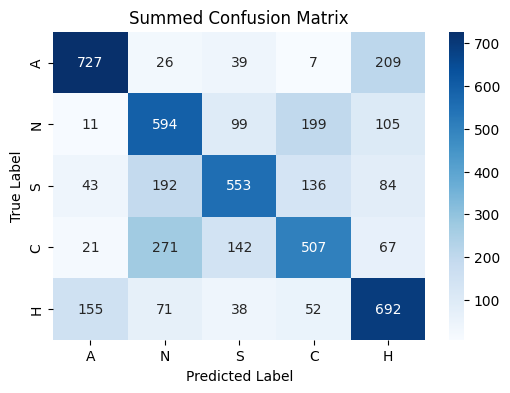

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

# 5FoldCV

## median n_epochs

In [33]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [34]:
acc = []
fscore = []
confusion = []
pt_cv_acc = []
pt_cv_fscore = []
pt_cv_confusion = []
patient_epochs = []
patient_best_epochs = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 56])
            y_train.extend (labels [i*80: i*80 + 56])
            x_test.extend (data [i*80 + 56: i*80 + 80])
            y_test.extend (labels [i*80 + 56: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{ x_test.shape}")
        
        # Shuffle data before splitting (ensuring class balance)
        indices = np.arange(len(x_train))
        np.random.seed(42)
        np.random.shuffle(indices)
        
        x_train = x_train[indices]
        y_train = np.array(y_train)[indices]
        
        # One-hot encode labels
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        # 5-Fold Stratified Cross-Validation (Ensures Equal Class Distribution)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_accuracies = []
        fold_f1 = []
        fold_cm = []
        fold_epochs = []
        
        for train_index, val_index in skf.split(x_train, y_train):
            x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
            y_fold_train, y_fold_val = train_labels_one_hot[train_index], train_labels_one_hot[val_index]
        
            audio_model = Sequential()
            audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.1))
            audio_model.add(MaxPooling1D(pool_size=(8)))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.5))
            audio_model.add(Flatten())
            audio_model.add(Dense(units=5,
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.l2(1e-4),
                            activity_regularizer=regularizers.l2(1e-5)
                            )
            ) # 7th layer
            audio_model.add(Activation('softmax'))
            
            # Compile Model
            audio_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
            # Early Stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train Model with Early Stopping
            history = audio_model.fit(x_fold_train, y_fold_train,
                                      validation_data=(x_fold_val, y_fold_val),
                                      epochs=100, batch_size=64, verbose=False,
                                      callbacks=[early_stopping])
        
            # Store best epoch count (the last epoch before stopping)
            best_epoch = len(history.history['val_loss']) - early_stopping.patience
            fold_epochs.append(best_epoch)

            # Get validation accuracy at the best epoch
            val_acc = max(history.history['val_accuracy'])
            fold_accuracies.append(val_acc)

            y_pred = audio_model.predict(x_fold_val)
            # Convert one-hot encoded ground truth labels to class labels
            y_true_labels = np.argmax(y_fold_val, axis=-1)

            f1 = f1_score(y_true_labels,np.argmax(y_pred, axis=-1),average='weighted')
            fold_f1.append(f1)

            confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
            cm = metrics.confusion_matrix(y_true_labels, np.argmax(y_pred, axis=-1))
            fold_cm.append(cm)
        
        patient_epochs.append(fold_epochs)
        patient_best_epochs.append(np.median(fold_epochs))
        pt_cv_acc.append(np.mean(fold_accuracies))
        pt_cv_fscore.append(np.mean(fold_f1))
        pt_cv_confusion.append(np.sum(fold_cm, axis=0))
        # Print Average Accuracy Across Folds
        print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}")
        print (f'F1: {np.mean(fold_f1):.4f}')
        print (f'Confusion: {np.sum(fold_cm, axis=0)}')
        print(f'Best n_epochs: {np.median(fold_epochs)}')

        final_model = Sequential()
        final_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.1))
        final_model.add(MaxPooling1D(pool_size=(8)))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.5))
        final_model.add(Flatten())
        final_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        final_model.add(Activation('softmax'))

        # Compile Model
        final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
        optimal_n_epochs = int(np.median(fold_epochs))
        # Train final model
        final_model.fit(x_train, train_labels_one_hot,
                        epochs=optimal_n_epochs, batch_size=64, verbose=True)
        
        # Evaluate on Test Data
        loss, accuracy = final_model.evaluate(x_test, test_labels_one_hot)
        y_pred = final_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)       


GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)
2/2 [==============================] - 0s 2ms/step
Average Cross-Validation Accuracy: 0.7571
F1: 0.7286
Confusion: [[43  2  3  1  7]
 [ 2 39 10  3  2]
 [ 7  7 35  6  1]
 [ 1  3  3 45  4]
 [ 8  0  4  2 42]]
Best n_epochs: 54.0
Epoch 1/54
5/5 [==============================] - 1s 3ms/step - loss: 3.4595 - accuracy: 0.1964
Epoch 2/54
5/5 [==============================] - 0s 3ms/step - loss: 2.0868 - accuracy: 0.1607
Epoch 3/54
5/5 [==============================] - 0s 2ms/step - loss: 1.8491 - accuracy: 0.2000
Epoch 4/54
5/5 [==============================] - 0s 3ms/step - loss: 1.8045 - accuracy: 0.2179
Epoch 5/54
5/5 [==============================] - 0s 2ms/step - loss: 1.7835 - accuracy: 0.2357
Epoch 6/54
5/5 [==============================] - 0s 3ms/step - loss: 1.7255 - accuracy: 0.2714
Epoch 7/54
5/5 [==============================] - 0s 2ms/ste

In [35]:
print(patient_epochs)

[[38, 56, 54, 70, 42], [41, 33, 27, 46, 32], [57, 33, 43, 62, 53], [67, 35, 37, 39, 42], [43, 38, 64, 54, 57], [34, 33, 63, 44, 38], [44, 24, 37, 51, 45], [36, 40, 37, 48, 41], [46, 49, 40, 40, 84], [54, 40, 55, 64, 54], [46, 38, 36, 56, 36], [50, 55, 50, 60, 67], [48, 44, 55, 29, 45], [50, 62, 53, 51, 52], [50, 59, 61, 51, 52], [52, 45, 42, 26, 80], [38, 37, 85, 46, 61], [39, 45, 48, 51, 60], [48, 48, 52, 27, 41], [50, 46, 37, 42, 36], [58, 41, 29, 65, 58], [44, 48, 45, 38, 55], [58, 31, 47, 63, 72], [53, 41, 44, 55, 56], [66, 58, 45, 36, 49], [67, 37, 54, 39, 51], [31, 61, 60, 51, 44], [48, 52, 38, 52, 61], [54, 51, 67, 66, 66], [64, 49, 49, 60, 40], [46, 39, 32, 44, 30], [49, 47, 66, 59, 51], [46, 58, 18, 37, 29], [51, 49, 36, 42, 37], [70, 51, 59, 53, 41], [55, 81, 69, 55, 52], [27, 31, 47, 44, 48], [70, 53, 54, 54, 41], [30, 34, 27, 34, 54], [38, 54, 30, 74, 40], [71, 37, 36, 37, 49], [61, 48, 53, 43, 58]]


In [36]:
print(patient_best_epochs)

[54.0, 33.0, 53.0, 39.0, 54.0, 38.0, 44.0, 40.0, 46.0, 54.0, 38.0, 55.0, 45.0, 52.0, 52.0, 45.0, 46.0, 48.0, 48.0, 42.0, 58.0, 45.0, 58.0, 53.0, 49.0, 51.0, 51.0, 52.0, 66.0, 49.0, 39.0, 51.0, 37.0, 42.0, 53.0, 55.0, 44.0, 54.0, 34.0, 40.0, 37.0, 53.0]


In [37]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.6047619034846624
Mean F1score across patients: 0.5929641571066875
Total Confusion Matrix: 
[[731  25  33   8 211]
 [ 21 598  78 212  99]
 [ 45 212 536 132  83]
 [ 13 289 146 513  47]
 [174  58  50  56 670]]


In [38]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

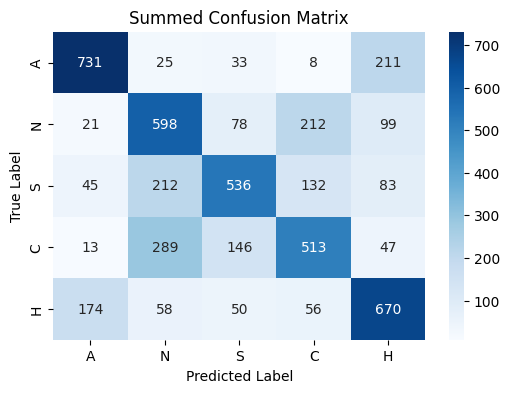

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

## mean n_epochs

In [26]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [27]:
acc = []
fscore = []
confusion = []
pt_cv_acc = []
pt_cv_fscore = []
pt_cv_confusion = []
patient_epochs = []
patient_best_epochs = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 56])
            y_train.extend (labels [i*80: i*80 + 56])
            x_test.extend (data [i*80 + 56: i*80 + 80])
            y_test.extend (labels [i*80 + 56: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{ x_test.shape}")
        
        # Shuffle data before splitting (ensuring class balance)
        indices = np.arange(len(x_train))
        np.random.seed(42)
        np.random.shuffle(indices)
        
        x_train = x_train[indices]
        y_train = np.array(y_train)[indices]
        
        # One-hot encode labels
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        # 5-Fold Stratified Cross-Validation (Ensures Equal Class Distribution)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_accuracies = []
        fold_f1 = []
        fold_cm = []
        fold_epochs = []
        
        for train_index, val_index in skf.split(x_train, y_train):
            x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
            y_fold_train, y_fold_val = train_labels_one_hot[train_index], train_labels_one_hot[val_index]
        
            audio_model = Sequential()
            audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.1))
            audio_model.add(MaxPooling1D(pool_size=(8)))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.5))
            audio_model.add(Flatten())
            audio_model.add(Dense(units=5,
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.l2(1e-4),
                            activity_regularizer=regularizers.l2(1e-5)
                            )
            ) # 7th layer
            audio_model.add(Activation('softmax'))
            
            # Compile Model
            audio_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
            # Early Stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train Model with Early Stopping
            history = audio_model.fit(x_fold_train, y_fold_train,
                                      validation_data=(x_fold_val, y_fold_val),
                                      epochs=100, batch_size=64, verbose=False,
                                      callbacks=[early_stopping])
        
            # Store best epoch count (the last epoch before stopping)
            best_epoch = len(history.history['val_loss']) - early_stopping.patience
            fold_epochs.append(best_epoch)

            # Get validation accuracy at the best epoch
            val_acc = max(history.history['val_accuracy'])
            fold_accuracies.append(val_acc)

            y_pred = audio_model.predict(x_fold_val)
            # Convert one-hot encoded ground truth labels to class labels
            y_true_labels = np.argmax(y_fold_val, axis=-1)

            f1 = f1_score(y_true_labels,np.argmax(y_pred, axis=-1),average='weighted')
            fold_f1.append(f1)

            confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
            cm = metrics.confusion_matrix(y_true_labels, np.argmax(y_pred, axis=-1))
            fold_cm.append(cm)
        
        patient_epochs.append(fold_epochs)
        patient_best_epochs.append(np.mean(fold_epochs))
        pt_cv_acc.append(np.mean(fold_accuracies))
        pt_cv_fscore.append(np.mean(fold_f1))
        pt_cv_confusion.append(np.sum(fold_cm, axis=0))
        # Print Average Accuracy Across Folds
        print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}")
        print (f'F1: {np.mean(fold_f1):.4f}')
        print (f'Confusion: {np.sum(fold_cm, axis=0)}')
        print(f'Best n_epochs: {np.mean(fold_epochs)}')

        final_model = Sequential()
        final_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.1))
        final_model.add(MaxPooling1D(pool_size=(8)))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.5))
        final_model.add(Flatten())
        final_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        final_model.add(Activation('softmax'))

        # Compile Model
        final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
        optimal_n_epochs = int(np.mean(fold_epochs))
        # Train final model
        final_model.fit(x_train, train_labels_one_hot,
                        epochs=optimal_n_epochs, batch_size=64, verbose=True)
        
        # Evaluate on Test Data
        loss, accuracy = final_model.evaluate(x_test, test_labels_one_hot)
        y_pred = final_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append(cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)       


GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)
2/2 [==============================] - 0s 2ms/step
Average Cross-Validation Accuracy: 0.7571
F1: 0.7210
Confusion: [[43  3  6  0  4]
 [ 3 40  9  4  0]
 [ 5  9 37  4  1]
 [ 0  5  4 46  1]
 [11  2  6  1 36]]
Best n_epochs: 44.8
Epoch 1/44
5/5 [==============================] - 1s 3ms/step - loss: 3.6647 - accuracy: 0.2179
Epoch 2/44
5/5 [==============================] - 0s 3ms/step - loss: 2.0035 - accuracy: 0.2286
Epoch 3/44
5/5 [==============================] - 0s 2ms/step - loss: 1.8917 - accuracy: 0.1964
Epoch 4/44
5/5 [==============================] - 0s 2ms/step - loss: 1.8677 - accuracy: 0.1893
Epoch 5/44
5/5 [==============================] - 0s 2ms/step - loss: 1.8065 - accuracy: 0.2036
Epoch 6/44
5/5 [==============================] - 0s 2ms/step - loss: 1.7530 - accuracy: 0.2071
Epoch 7/44
5/5 [==============================] - 0s 2ms/ste

In [28]:
print(patient_epochs)

[[42, 46, 51, 46, 39], [38, 31, 29, 40, 59], [50, 37, 51, 58, 50], [41, 34, 35, 37, 65], [47, 30, 61, 64, 72], [41, 35, 50, 63, 41], [39, 42, 50, 66, 82], [33, 33, 30, 45, 42], [36, 57, 53, 38, 90], [47, 42, 36, 69, 75], [35, 34, 42, 54, 46], [52, 71, 51, 48, 66], [55, 40, 62, 51, 42], [77, 60, 45, 47, 47], [46, 41, 82, 45, 64], [51, 41, 35, 28, 66], [36, 81, 90, 65, 62], [62, 55, 57, 42, 42], [56, 46, 49, 44, 32], [37, 38, 41, 47, 41], [57, 56, 50, 66, 53], [43, 57, 44, 44, 52], [61, 56, 45, 46, 57], [56, 44, 40, 45, 56], [72, 64, 62, 40, 52], [80, 51, 48, 41, 43], [33, 57, 50, 40, 42], [41, 47, 49, 36, 39], [71, 45, 72, 70, 70], [50, 53, 51, 79, 64], [61, 43, 32, 54, 49], [40, 51, 46, 46, 49], [41, 53, 32, 48, 31], [58, 37, 38, 39, 40], [63, 45, 64, 55, 40], [47, 72, 58, 78, 62], [14, 46, 45, 39, 43], [71, 49, 62, 57, 52], [27, 44, 32, 31, 42], [29, 53, 44, 61, 38], [79, 42, 61, 40, 37], [49, 74, 59, 59, 64]]


In [29]:
print(patient_best_epochs)

[44.8, 39.4, 49.2, 42.4, 54.8, 46.0, 55.8, 36.6, 54.8, 53.8, 42.2, 57.6, 50.0, 55.2, 55.6, 44.2, 66.8, 51.6, 45.4, 40.8, 56.4, 48.0, 53.0, 48.2, 58.0, 52.6, 44.4, 42.4, 65.6, 59.4, 47.8, 46.4, 41.0, 42.4, 53.4, 63.4, 37.4, 58.2, 35.2, 45.0, 51.8, 61.0]


In [30]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.6049603195417494
Mean F1score across patients: 0.5969756620597396
Total Confusion Matrix: 
[[740  30  45   6 187]
 [ 23 621  92 187  85]
 [ 48 196 550 133  81]
 [ 24 261 166 508  49]
 [202  63  60  53 630]]


In [31]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

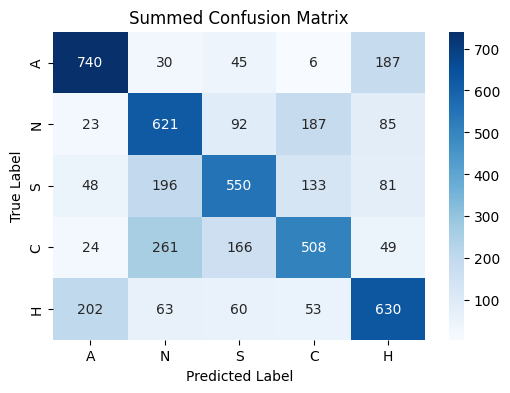

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

# 5FoldCV

## median n_epochs

In [4]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [6]:
acc = []
fscore = []
confusion = []
pt_cv_acc = []
pt_cv_fscore = []
pt_cv_confusion = []
patient_epochs = []
patient_best_epochs = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels = [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data (audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                idx+=1

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 56])
            y_train.extend (labels [i*80: i*80 + 56])
            x_test.extend (data [i*80 + 56: i*80 + 80])
            y_test.extend (labels [i*80 + 56: i*80 + 80])
        
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{ x_test.shape}")
        
        # One-hot encode labels
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        # 5-Fold Stratified Cross-Validation (Ensures Equal Class Distribution)
        skf = StratifiedKFold(n_splits=5, shuffle=False)
        fold_accuracies = []
        fold_f1 = []
        fold_cm = []
        fold_epochs = []
        
        for train_index, val_index in skf.split(x_train, y_train):
            x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
            y_fold_train, y_fold_val = train_labels_one_hot[train_index], train_labels_one_hot[val_index]
        
            audio_model = Sequential()
            audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.1))
            audio_model.add(MaxPooling1D(pool_size=(8)))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.5))
            audio_model.add(Flatten())
            audio_model.add(Dense(units=5,
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.l2(1e-4),
                            activity_regularizer=regularizers.l2(1e-5)
                            )
            ) # 7th layer
            audio_model.add(Activation('softmax'))
            
            # Compile Model
            audio_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
            # Early Stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train Model with Early Stopping
            history = audio_model.fit(x_fold_train, y_fold_train,
                                      validation_data=(x_fold_val, y_fold_val),
                                      epochs=100, batch_size=64, verbose=False,
                                      callbacks=[early_stopping])
        
            # Store best epoch count (the last epoch before stopping)
            best_epoch = len(history.history['val_loss']) - early_stopping.patience
            fold_epochs.append(best_epoch)

            # Get validation accuracy at the best epoch
            val_acc = max(history.history['val_accuracy'])
            fold_accuracies.append(val_acc)

            y_pred = audio_model.predict(x_fold_val)
            # Convert one-hot encoded ground truth labels to class labels
            y_true_labels = np.argmax(y_fold_val, axis=-1)

            f1 = f1_score(y_true_labels,np.argmax(y_pred, axis=-1),average='weighted')
            fold_f1.append(f1)

            confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
            cm = metrics.confusion_matrix(y_true_labels, np.argmax(y_pred, axis=-1))
            fold_cm.append(cm)
        
        patient_epochs.append(fold_epochs)
        patient_best_epochs.append(np.median(fold_epochs))
        pt_cv_acc.append(np.mean(fold_accuracies))
        pt_cv_fscore.append(np.mean(fold_f1))
        pt_cv_confusion.append(np.sum(fold_cm, axis=0))
        # Print Average Accuracy Across Folds
        print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}")
        print (f'F1: {np.mean(fold_f1):.4f}')
        print (f'Confusion: {np.sum(fold_cm, axis=0)}')
        print(f'Best n_epochs: {np.median(fold_epochs)}')

        final_model = Sequential()
        final_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.1))
        final_model.add(MaxPooling1D(pool_size=(8)))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.5))
        final_model.add(Flatten())
        final_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        final_model.add(Activation('softmax'))

        # Compile Model
        final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
        optimal_n_epochs = int(np.median(fold_epochs))
        # Train final model
        final_model.fit(x_train, train_labels_one_hot,
                        epochs=optimal_n_epochs, batch_size=64, verbose=True)
        
        # Evaluate on Test Data
        loss, accuracy = final_model.evaluate(x_test, test_labels_one_hot)
        y_pred = final_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)       


GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)
2/2 [==============================] - 0s 2ms/step
Average Cross-Validation Accuracy: 0.5964
F1: 0.5196
Confusion: [[27  3  9  3 14]
 [ 2 30 11 12  1]
 [ 5 16 26  5  4]
 [ 0 13 10 31  2]
 [14  0  5  1 36]]
Best n_epochs: 32.0
Epoch 1/32
5/5 [==============================] - 1s 4ms/step - loss: 3.5433 - accuracy: 0.2071
Epoch 2/32
5/5 [==============================] - 0s 2ms/step - loss: 2.0247 - accuracy: 0.2143
Epoch 3/32
5/5 [==============================] - 0s 2ms/step - loss: 1.9374 - accuracy: 0.1679
Epoch 4/32
5/5 [==============================] - 0s 2ms/step - loss: 1.8453 - accuracy: 0.1750
Epoch 5/32
5/5 [==============================] - 0s 2ms/step - loss: 1.7648 - accuracy: 0.2143
Epoch 6/32
5/5 [==============================] - 0s 2ms/step - loss: 1.7719 - accuracy: 0.2071
Epoch 7/32
5/5 [==============================] - 0s 2ms/ste

In [7]:
print(patient_epochs)

[[15, 32, 40, 24, 51], [40, 19, 21, 29, 17], [33, 70, 54, 48, 33], [35, 34, 28, 50, 29], [34, 32, 34, 41, 9], [17, 46, 38, 51, 33], [25, 64, 33, 53, 7], [33, 33, 38, 44, 20], [28, 42, 55, 44, 27], [14, 46, 49, 30, 25], [50, 36, 39, 14, 33], [11, 50, 37, 56, 16], [37, 26, 65, 50, 37], [74, 38, 49, 50, 22], [9, 11, 72, 43, 39], [27, 39, 30, 24, 31], [60, 54, 49, 36, 16], [34, 45, 44, 46, 28], [36, 44, 10, 24, 17], [38, 36, 32, 43, 29], [40, 56, 47, 32, 15], [21, 54, 37, 39, 15], [14, 47, 31, 44, 27], [27, 39, 40, 48, 25], [22, 48, 68, 27, 26], [21, 58, 36, 31, 18], [30, 46, 43, 22, 24], [49, 41, 29, 48, 20], [38, 66, 58, 45, 20], [41, 49, 39, 28, 27], [32, 45, 51, 33, 28], [43, 61, 43, 55, 33], [20, 29, 37, 35, 19], [17, 43, 41, 31, 7], [57, 46, 56, 20, 19], [39, 44, 39, 28, 13], [34, 36, 17, 44, 6], [23, 58, 41, 14, 25], [29, 22, 17, 30, 17], [29, 29, 34, 12, 19], [56, 69, 29, 42, 18], [41, 40, 32, 26, 10]]


In [8]:
print(patient_best_epochs)

[32.0, 21.0, 48.0, 34.0, 34.0, 38.0, 33.0, 33.0, 42.0, 30.0, 36.0, 37.0, 37.0, 49.0, 39.0, 30.0, 49.0, 44.0, 24.0, 36.0, 40.0, 37.0, 31.0, 39.0, 27.0, 31.0, 30.0, 41.0, 45.0, 39.0, 33.0, 43.0, 29.0, 31.0, 46.0, 39.0, 34.0, 25.0, 22.0, 29.0, 42.0, 32.0]


In [9]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.5896825364657811
Mean F1score across patients: 0.5822249999249205
Total Confusion Matrix: 
[[741  22  37  13 195]
 [ 23 537 109 245  94]
 [ 45 180 532 163  88]
 [ 14 231 152 550  61]
 [200  60  77  59 612]]


In [10]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

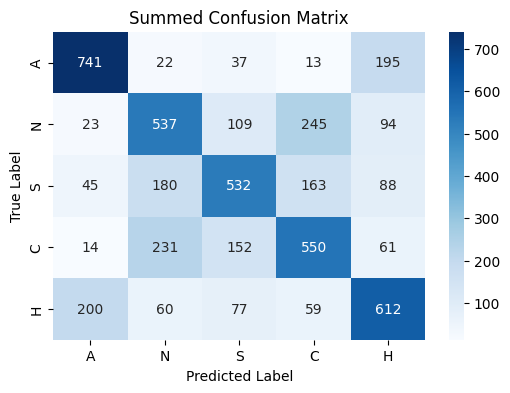

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

In [12]:
print(f"Mean Accuracy across patients: {np.mean(pt_cv_acc)}") #test
print(f"Mean F1score across patients: {np.mean(pt_cv_fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(pt_cv_confusion, axis=0)}")

Mean Accuracy across patients: 0.7144557820899146
Mean F1score across patients: 0.6665275511327009
Total Confusion Matrix: 
[[1844   49   76   35  348]
 [  43 1375  269  554  111]
 [  50  273 1651  240  138]
 [  26  519  295 1401  111]
 [ 357  102  144   82 1667]]


In [13]:
# Data

# Group Kfold

In [15]:
from sklearn.model_selection import StratifiedGroupKFold

In [17]:
acc = []
fscore = []
confusion = []
pt_cv_acc = []
pt_cv_fscore = []
pt_cv_confusion = []
patient_epochs = []
patient_best_epochs = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels, groups = [], [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        group_id = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data(audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                # Assign the same group ID for all samples from the same file
                groups.extend([group_id] * len(x))
                
                idx += 1
                group_id += 1  # Increment group ID for the next file

        x_train = []
        y_train = []
        group_train = []
        x_test = []
        y_test = []
        
        for i, emotion in enumerate (emotions):
            x_train.extend (data [i*80: i*80 + 56])
            y_train.extend (labels [i*80: i*80 + 56])
            group_train.extend(groups[i * 80 : i * 80 + 56])
            x_test.extend (data [i*80 + 56: i*80 + 80])
            y_test.extend (labels [i*80 + 56: i*80 + 80])
        
        x_train = np.array(x_train)
        group_train = np.array(group_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{ x_test.shape}")
        
        # One-hot encode labels
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        # 5-Fold Stratified Cross-Validation (Ensures Equal Class Distribution)
        fold_accuracies = []
        fold_f1 = []
        fold_cm = []
        fold_epochs = []
        
        # Stratified Group K-Fold (Ensuring class balance while keeping groups intact)
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_index, val_index in skf.split(x_train, y_train, groups=group_train):
            x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
            y_fold_train, y_fold_val = train_labels_one_hot[train_index], train_labels_one_hot[val_index]
            print(f"Train fold size: {x_fold_train.shape}, Val fold size: {x_fold_val.shape}")
        
            audio_model = Sequential()
            audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.1))
            audio_model.add(MaxPooling1D(pool_size=(8)))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.5))
            audio_model.add(Flatten())
            audio_model.add(Dense(units=5,
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.l2(1e-4),
                            activity_regularizer=regularizers.l2(1e-5)
                            )
            ) # 7th layer
            audio_model.add(Activation('softmax'))
            
            # Compile Model
            audio_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
            # Early Stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train Model with Early Stopping
            history = audio_model.fit(x_fold_train, y_fold_train,
                                      validation_data=(x_fold_val, y_fold_val),
                                      epochs=100, batch_size=64, verbose=False,
                                      callbacks=[early_stopping])
        
            # Store best epoch count (the last epoch before stopping)
            best_epoch = len(history.history['val_loss']) - early_stopping.patience
            fold_epochs.append(best_epoch)

            # Get validation accuracy at the best epoch
            val_acc = max(history.history['val_accuracy'])
            fold_accuracies.append(val_acc)

            y_pred = audio_model.predict(x_fold_val)
            # Convert one-hot encoded ground truth labels to class labels
            y_true_labels = np.argmax(y_fold_val, axis=-1)

            f1 = f1_score(y_true_labels,np.argmax(y_pred, axis=-1),average='weighted')
            fold_f1.append(f1)

            confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
            cm = metrics.confusion_matrix(y_true_labels, np.argmax(y_pred, axis=-1))
            fold_cm.append(cm)
        
        patient_epochs.append(fold_epochs)
        patient_best_epochs.append(np.median(fold_epochs))
        pt_cv_acc.append(np.mean(fold_accuracies))
        pt_cv_fscore.append(np.mean(fold_f1))
        pt_cv_confusion.append(np.sum(fold_cm, axis=0))
        # Print Average Accuracy Across Folds
        print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}")
        print (f'F1: {np.mean(fold_f1):.4f}')
        print (f'Confusion: {np.sum(fold_cm, axis=0)}')
        print(f'Best n_epochs: {np.median(fold_epochs)}')

        final_model = Sequential()
        final_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.1))
        final_model.add(MaxPooling1D(pool_size=(8)))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.5))
        final_model.add(Flatten())
        final_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        final_model.add(Activation('softmax'))

        # Compile Model
        final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
        optimal_n_epochs = int(np.median(fold_epochs))
        # Train final model
        final_model.fit(x_train, train_labels_one_hot,
                        epochs=optimal_n_epochs, batch_size=64, verbose=True)
        
        # Evaluate on Test Data
        loss, accuracy = final_model.evaluate(x_test, test_labels_one_hot)
        y_pred = final_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)       


GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Average Cross-Validation Accuracy: 0.6857
F1: 0.6504
Confusion: [[40  4  4  1  7]
 [ 2 32 10 11  1]
 [ 5 10 33  5  3]
 [ 1  9  4 40  2]
 [11  0  6  2 37]]
Best n_epochs: 39.0
Epoch 1/39
5/5 [==============================] - 1s 4ms/step - loss: 3.8964 - accuracy: 0.2036
Epoch 2/39
5/5 [====================

In [18]:
print(patient_epochs)

[[41, 41, 32, 24, 39], [38, 35, 32, 33, 58], [31, 47, 38, 51, 51], [36, 24, 29, 34, 63], [60, 32, 41, 37, 36], [36, 26, 29, 46, 57], [44, 39, 31, 31, 33], [43, 44, 48, 30, 46], [48, 56, 42, 18, 50], [67, 56, 20, 33, 58], [43, 44, 30, 35, 37], [20, 47, 33, 27, 45], [43, 48, 28, 37, 46], [52, 57, 24, 37, 44], [52, 14, 20, 25, 17], [40, 40, 39, 30, 70], [38, 47, 53, 41, 32], [29, 39, 45, 20, 48], [26, 42, 45, 31, 54], [40, 34, 31, 32, 41], [64, 40, 47, 49, 54], [41, 40, 28, 37, 55], [44, 40, 33, 40, 31], [64, 59, 35, 40, 53], [52, 47, 34, 32, 50], [20, 41, 42, 49, 52], [45, 37, 21, 48, 42], [29, 27, 44, 44, 43], [64, 58, 59, 41, 62], [46, 51, 34, 51, 38], [32, 50, 43, 38, 33], [46, 52, 32, 42, 34], [55, 24, 27, 16, 38], [25, 46, 35, 21, 38], [32, 39, 33, 36, 46], [52, 57, 31, 28, 36], [22, 44, 7, 18, 37], [41, 60, 53, 58, 47], [32, 59, 27, 25, 32], [37, 36, 13, 33, 46], [19, 42, 81, 51, 40], [53, 67, 44, 45, 41]]


In [19]:
print(patient_best_epochs)

[39.0, 35.0, 47.0, 34.0, 37.0, 36.0, 33.0, 44.0, 48.0, 56.0, 37.0, 33.0, 43.0, 44.0, 20.0, 40.0, 41.0, 39.0, 42.0, 34.0, 49.0, 40.0, 40.0, 53.0, 47.0, 42.0, 42.0, 43.0, 59.0, 46.0, 38.0, 42.0, 27.0, 35.0, 36.0, 36.0, 22.0, 53.0, 32.0, 36.0, 42.0, 45.0]


In [20]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.6071428578524363
Mean F1score across patients: 0.5999246244753996
Total Confusion Matrix: 
[[731  23  42   5 207]
 [ 19 582  97 215  95]
 [ 43 194 574 145  52]
 [ 17 255 188 499  49]
 [167  58  65  44 674]]


In [21]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

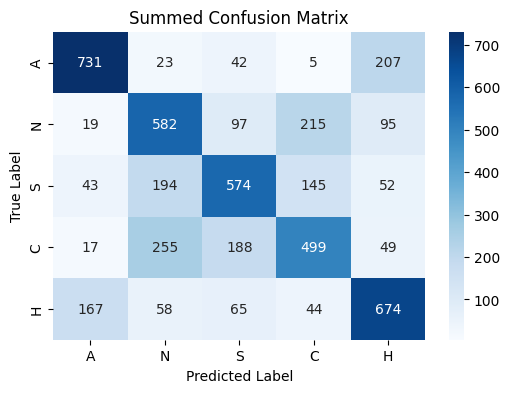

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

In [23]:
print(f"Mean Accuracy across patients: {np.mean(pt_cv_acc)}") #test
print(f"Mean F1score across patients: {np.mean(pt_cv_fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(pt_cv_confusion, axis=0)}")

Mean Accuracy across patients: 0.7610544211807705
Mean F1score across patients: 0.7261132521345779
Total Confusion Matrix: 
[[1957   57   45   28  265]
 [  34 1465  247  517   89]
 [  44  238 1745  209  116]
 [  23  432  182 1643   72]
 [ 308  102  105   66 1771]]


# Groupings

In [25]:
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels, groups = [], [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        X, y = load_test_data(audio_path)
        idx = 0
        group_id = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data(audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                print(np.array(x).shape)
                # Assign the same group ID for all samples from the same file
                groups.extend([group_id] * len(x))
                
                idx += 1
                group_id += 1  # Increment group ID for the next file
        
        break

GitHub_Codes
subject1
/opt/scratchspace/mbibars/eeg/data/EAV/subject1/Audio
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)
(4, 180)


In [26]:
np.array(data).shape

(400, 180)

In [27]:
len(groups)

400

In [29]:
np.unique(groups, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

In [30]:
from sklearn.model_selection import GroupShuffleSplit

In [34]:
groups = np.array(groups)
y = np.array(labels)
X = np.array(data)
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
gss.get_n_splits()
print(gss)
for i, (train_index, test_index) in enumerate(gss.split(X,y ,groups )):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")

GroupShuffleSplit(n_splits=1, random_state=42, test_size=None, train_size=0.7)
Fold 0:
  Train: index=[  4   5   6   7   8   9  10  11  12  13  14  15  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  44  45  46  47  52  53  54  55
  56  57  58  59  64  65  66  67  68  69  70  71  76  77  78  79  80  81
  82  83  84  85  86  87  92  93  94  95  96  97  98  99 100 101 102 103
 108 109 110 111 112 113 114 115 116 117 118 119 128 129 130 131 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 164 165 166 167 172 173 174 175 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 216 217 218 219 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 284 285 286 287 296 297 298 299 300 301 302 303 312 313 314 315
 316 317 318 319 324 3

# Group Kfold random test set

In [6]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [7]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit

In [8]:
acc = []
fscore = []
confusion = []
pt_cv_acc = []
pt_cv_fscore = []
pt_cv_confusion = []
patient_epochs = []
patient_best_epochs = []

root_folder = "/opt/scratchspace/mbibars/eeg/data/EAV"

emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
for subfolder in sorted(os.listdir(root_folder), key = sort_cmp):
    print(subfolder)
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    data, labels, groups = [], [], []
    if os.path.exists(audio_path):
        all_files = sorted(os.listdir(audio_path))
        for file in all_files:
            if file.endswith(".wav"):
                for emotion in emotions:
                    if emotion in file:
                        if (emotion != 'Neutral' and file.count ('Neutral') > 0):
                            continue
                        audio_path2 = os.path.join(audio_path, file)
                        categorized_files[emotion].append(audio_path2)
        
        idx = 0
        group_id = 0
        
        for class_index, emotion in enumerate(emotions):
            for file_index, audio_path2 in enumerate(categorized_files[emotion]):
                x,y = proc_data(audio_path2, emotion)        
                data.extend(x)
                labels.extend(y)
                # Assign the same group ID for all samples from the same file
                groups.extend([group_id] * len(x))
                
                idx += 1
                group_id += 1  # Increment group ID for the next file
        data = np.array(data)
        labels = np.array(labels)
        groups = np.array(groups)
        
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
        train_index, test_index = next(splitter.split(data, labels, groups))
        
        x_train, x_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        group_train, group_test = groups[train_index], groups[test_index]
            
        #x_train = np.array(x_train)
        #group_train = np.array(group_train)
        #x_test = np.array(x_test)
        #y_train = np.array(y_train)
        #y_test = np.array(y_test)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        print(f"Shapes for {subfolder} : train {x_train.shape}, test:{x_test.shape}")
        
        # One-hot encode labels
        identity_matrix = np.eye(len(emotions))
        train_labels_one_hot = np.array([identity_matrix[label] for label in y_train])
        test_labels_one_hot = np.array([identity_matrix[label] for label in y_test])
        
        # 5-Fold Stratified Cross-Validation (Ensures Equal Class Distribution)
        fold_accuracies = []
        fold_f1 = []
        fold_cm = []
        fold_epochs = []
        
        # Stratified Group K-Fold (Ensuring class balance while keeping groups intact)
        skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_index, val_index in skf.split(x_train, y_train, groups=group_train):
            x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
            y_fold_train, y_fold_val = train_labels_one_hot[train_index], train_labels_one_hot[val_index]
            print(f"Train fold size: {x_fold_train.shape}, Val fold size: {x_fold_val.shape}")
        
            audio_model = Sequential()
            audio_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.1))
            audio_model.add(MaxPooling1D(pool_size=(8)))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
            audio_model.add(Activation('relu'))
            audio_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
            audio_model.add(Activation('relu'))
            audio_model.add(Dropout(0.5))
            audio_model.add(Flatten())
            audio_model.add(Dense(units=5,
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.l2(1e-4),
                            activity_regularizer=regularizers.l2(1e-5)
                            )
            ) # 7th layer
            audio_model.add(Activation('softmax'))
            
            # Compile Model
            audio_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
            # Early Stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train Model with Early Stopping
            history = audio_model.fit(x_fold_train, y_fold_train,
                                      validation_data=(x_fold_val, y_fold_val),
                                      epochs=100, batch_size=64, verbose=False,
                                      callbacks=[early_stopping])
        
            # Store best epoch count (the last epoch before stopping)
            best_epoch = len(history.history['val_loss']) - early_stopping.patience
            fold_epochs.append(best_epoch)

            # Get validation accuracy at the best epoch
            val_acc = max(history.history['val_accuracy'])
            fold_accuracies.append(val_acc)

            y_pred = audio_model.predict(x_fold_val)
            # Convert one-hot encoded ground truth labels to class labels
            y_true_labels = np.argmax(y_fold_val, axis=-1)

            f1 = f1_score(y_true_labels,np.argmax(y_pred, axis=-1),average='weighted')
            fold_f1.append(f1)

            confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
            cm = metrics.confusion_matrix(y_true_labels, np.argmax(y_pred, axis=-1))
            fold_cm.append(cm)
        
        patient_epochs.append(fold_epochs)
        patient_best_epochs.append(np.median(fold_epochs))
        pt_cv_acc.append(np.mean(fold_accuracies))
        pt_cv_fscore.append(np.mean(fold_f1))
        pt_cv_confusion.append(np.sum(fold_cm, axis=0))
        # Print Average Accuracy Across Folds
        print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}")
        print (f'F1: {np.mean(fold_f1):.4f}')
        print (f'Confusion: {np.sum(fold_cm, axis=0)}')
        print(f'Best n_epochs: {np.median(fold_epochs)}')

        final_model = Sequential()
        final_model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.1))
        final_model.add(MaxPooling1D(pool_size=(8)))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
        final_model.add(Activation('relu'))
        final_model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
        final_model.add(Activation('relu'))
        final_model.add(Dropout(0.5))
        final_model.add(Flatten())
        final_model.add(Dense(units=5,
                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.l2(1e-4),
                        activity_regularizer=regularizers.l2(1e-5)
                        )
        ) # 7th layer
        final_model.add(Activation('softmax'))

        # Compile Model
        final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                loss='categorical_crossentropy', metrics=['accuracy'])
        
        optimal_n_epochs = int(np.median(fold_epochs))
        # Train final model
        final_model.fit(x_train, train_labels_one_hot,
                        epochs=optimal_n_epochs, batch_size=64, verbose=True)
        
        # Evaluate on Test Data
        loss, accuracy = final_model.evaluate(x_test, test_labels_one_hot)
        y_pred = final_model.predict(x_test)
        f1 = f1_score(y_test,np.argmax(y_pred, axis=-1),average='weighted')
        acc.append (accuracy)
        fscore.append (f1)
        confusion_emotions = ["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]
        cm = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=-1))
        confusion.append (cm)
        print(f"Audio Accuracy for {subfolder} : {accuracy * 100:.2f}%")
        print ('F1: ', f1)
        print ('Confusion:', cm)       


GitHub_Codes
subject1
Shapes for subject1 : train (280, 180, 1), test:(120, 180, 1)
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)


2025-04-04 23:33:42.302302: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-04 23:33:42.367569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-04 23:33:42.437690: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-04 23:33:43.022362: I external/local_xla/xla/service/service.cc:168] XLA service 0x14bc18bcb490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-04 23:33:43.022404: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-04-04 23:33:43.026727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743824023.085073 3875316 device_compiler.h:186] Compi

2/2 [==============================] - 0s 63ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 1ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Train fold size: (224, 180, 1), Val fold size: (56, 180, 1)
2/2 [==============================] - 0s 2ms/step
Average Cross-Validation Accuracy: 0.7179
F1: 0.6679
Confusion: [[31  2  7  0 12]
 [ 0 37  8  9  2]
 [ 6  5 39  1  5]
 [ 0 13  2 37  4]
 [ 7  1  3  4 45]]
Best n_epochs: 39.0
Epoch 1/39
5/5 [==============================] - 1s 44ms/step - loss: 3.3245 - accuracy: 0.1821
Epoch 2/39
5/5 [==============================] - 0s 2ms/step - loss: 2.0663 - accuracy: 0.1964
Epoch 3/39
5/5 [==============================] - 0s 2ms/step - loss: 1.8950 - accuracy: 0.1964
Epoch 4/39
5/5 [========================

In [9]:
print(patient_epochs)

[[41, 41, 37, 25, 39], [26, 31, 23, 24, 46], [48, 60, 57, 44, 42], [36, 36, 29, 49, 32], [53, 43, 45, 38, 47], [27, 51, 38, 39, 32], [32, 61, 33, 39, 58], [30, 38, 37, 35, 25], [44, 33, 38, 37, 55], [36, 46, 51, 54, 34], [40, 31, 52, 37, 30], [45, 50, 56, 46, 36], [34, 34, 36, 37, 31], [42, 39, 41, 59, 31], [45, 39, 47, 50, 33], [54, 40, 41, 49, 29], [50, 45, 54, 46, 21], [38, 58, 49, 40, 46], [32, 32, 20, 21, 44], [34, 42, 6, 36, 36], [51, 79, 39, 48, 37], [32, 35, 28, 35, 49], [46, 35, 23, 52, 45], [41, 40, 42, 21, 58], [57, 38, 42, 46, 40], [48, 46, 40, 31, 36], [37, 34, 36, 44, 27], [49, 24, 58, 38, 22], [52, 60, 31, 29, 52], [43, 35, 38, 66, 37], [36, 23, 39, 45, 53], [30, 47, 50, 28, 53], [39, 37, 11, 37, 25], [25, 36, 47, 33, 36], [39, 32, 39, 40, 41], [50, 76, 57, 41, 42], [41, 29, 49, 30, 44], [28, 48, 21, 27, 25], [42, 18, 31, 37, 51], [26, 35, 37, 34, 21], [64, 43, 39, 25, 35], [54, 27, 62, 52, 43]]


In [10]:
print(patient_best_epochs)

[39.0, 26.0, 48.0, 36.0, 45.0, 38.0, 39.0, 35.0, 38.0, 46.0, 37.0, 46.0, 34.0, 41.0, 45.0, 41.0, 46.0, 46.0, 32.0, 36.0, 48.0, 35.0, 45.0, 41.0, 42.0, 40.0, 36.0, 38.0, 52.0, 38.0, 39.0, 47.0, 37.0, 36.0, 39.0, 50.0, 41.0, 27.0, 37.0, 34.0, 39.0, 52.0]


In [11]:
print(f"Mean Accuracy across patients: {np.mean(acc)}") #test
print(f"Mean F1score across patients: {np.mean(fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(confusion, axis=0)}")

Mean Accuracy across patients: 0.6845238102333886
Mean F1score across patients: 0.6797883765113779
Total Confusion Matrix: 
[[963  40  32  14 127]
 [  8 599 163 205  33]
 [ 14 123 673 156  42]
 [  5 264  79 615  45]
 [149  38  29  24 600]]


In [12]:
# rows are True, cols are predicted
["Anger", "Neutral", "Sadness", "Calmness", "Happiness"]

['Anger', 'Neutral', 'Sadness', 'Calmness', 'Happiness']

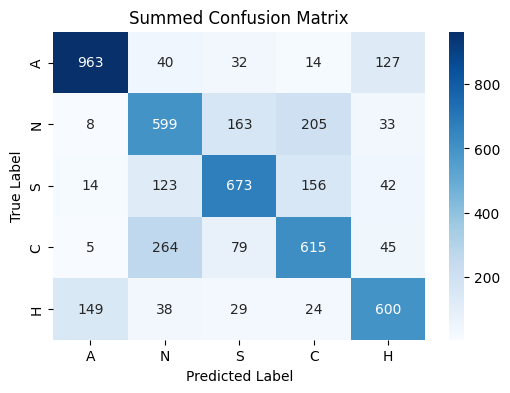

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define labels
labels = ['A', 'N', 'S', 'C', 'H']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.sum(confusion, axis=0), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Summed Confusion Matrix")

# Show the plot
plt.show()

In [15]:
print(f"CV Mean Accuracy across patients: {np.mean(pt_cv_acc)}") #test
print(f"CV Mean F1score across patients: {np.mean(pt_cv_fscore)}")
print(f"Total Confusion Matrix: \n{np.sum(pt_cv_confusion, axis=0)}")

CV Mean Accuracy across patients: 0.7572278916835785
CV Mean F1score across patients: 0.7217573791286717
Total Confusion Matrix: 
[[1719   47   73   23  322]
 [  19 1445  263  490  135]
 [  46  202 1785  214  105]
 [  11  453  206 1603   79]
 [ 230  141  100   57 1992]]


# Stratified kfold all patients

In [16]:
# Aggregated training and test sets
x_train_all, y_train_all = [], []
x_test_all, y_test_all = [], []

for subfolder in sorted(os.listdir(root_folder), key=sort_cmp):
    print(f"Processing: {subfolder}")
    categorized_files = {emotion: [] for emotion in emotions}
    subfolder_path = os.path.join(root_folder, subfolder)
    audio_path = os.path.join(subfolder_path, 'Audio')
    if not os.path.exists(audio_path): continue

    all_files = sorted(os.listdir(audio_path))
    for file in all_files:
        if file.endswith(".wav"):
            for emotion in emotions:
                if emotion in file and (emotion != 'Neutral' or file.count('Neutral') == 1):
                    categorized_files[emotion].append(os.path.join(audio_path, file))

    data, labels = [], []
    for class_index, emotion in enumerate(emotions):
        for file_path in categorized_files[emotion]:
            x, y = proc_data(file_path, emotion)
            data.extend(x)
            labels.extend(y)

    # Assuming 80 samples per emotion per subject
    for i in range(len(emotions)):
        start = i * 80
        x_train_all.extend(data[start:start + 56])
        y_train_all.extend(labels[start:start + 56])
        x_test_all.extend(data[start + 56:start + 80])
        y_test_all.extend(labels[start + 56:start + 80])

# Convert and reshape
x_train_all = np.expand_dims(np.array(x_train_all), axis=2)
x_test_all = np.expand_dims(np.array(x_test_all), axis=2)
y_train_all = np.array(y_train_all)
y_test_all = np.array(y_test_all)

# One-hot encode
identity_matrix = np.eye(len(emotions))
y_train_onehot = np.array([identity_matrix[label] for label in y_train_all])
y_test_onehot = np.array([identity_matrix[label] for label in y_test_all])

# Cross-validation to select optimal n_epochs
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
cv_f1s = []
cv_cms = []
cv_epochs = []

for train_idx, val_idx in skf.split(x_train_all, y_train_all):
    x_tr, x_val = x_train_all[train_idx], x_train_all[val_idx]
    y_tr, y_val = y_train_onehot[train_idx], y_train_onehot[val_idx]

    model = Sequential([
        Conv1D(256, 5, padding='same', input_shape=(180,1)), Activation('relu'),
        Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4)), Activation('relu'),
        Dropout(0.1), MaxPooling1D(pool_size=8),
        Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4)), Activation('relu'),
        Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4)), Activation('relu'),
        Dropout(0.5), Flatten(),
        Dense(5, kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-5)),
        Activation('softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=100,
                        batch_size=64, callbacks=[early_stop], verbose=False)

    best_epoch = len(history.history['val_loss']) - early_stop.patience
    val_acc = max(history.history['val_accuracy'])
    y_pred = model.predict(x_val)
    f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='weighted')
    cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

    cv_accuracies.append(val_acc)
    cv_f1s.append(f1)
    cv_cms.append(cm)
    cv_epochs.append(best_epoch)

print(f"Cross-Validation Accuracy: {np.mean(cv_accuracies):.4f}")
print(f"Cross-Validation F1: {np.mean(cv_f1s):.4f}")
print("Confusion Matrix (sum over folds):\n", np.sum(cv_cms, axis=0))
print(f"Selected n_epochs: {int(np.median(cv_epochs))}")

# Train final model on full train set
final_model = tf.keras.models.clone_model(model)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(x_train_all, y_train_onehot, epochs=int(np.median(cv_epochs)), batch_size=64, verbose=True)

# Evaluate on test set
test_loss, test_acc = final_model.evaluate(x_test_all, y_test_onehot)
y_pred = final_model.predict(x_test_all)
test_f1 = f1_score(y_test_all, np.argmax(y_pred, axis=1), average='weighted')
test_cm = confusion_matrix(y_test_all, np.argmax(y_pred, axis=1))

print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")
print(f"Final Test F1 Score: {test_f1:.4f}")
print("Final Test Confusion Matrix:\n", test_cm)

Processing: GitHub_Codes
Processing: subject1
Processing: subject2
Processing: subject3
Processing: subject4
Processing: subject5
Processing: subject6
Processing: subject7
Processing: subject8
Processing: subject9
Processing: subject10
Processing: subject11
Processing: subject12
Processing: subject13
Processing: subject14
Processing: subject15
Processing: subject16
Processing: subject17
Processing: subject18
Processing: subject19
Processing: subject20
Processing: subject21
Processing: subject22
Processing: subject23
Processing: subject24
Processing: subject25
Processing: subject26
Processing: subject27
Processing: subject28
Processing: subject29
Processing: subject30
Processing: subject31
Processing: subject32
Processing: subject33
Processing: subject34
Processing: subject35
Processing: subject36
Processing: subject37
Processing: subject38
Processing: subject39
Processing: subject40
Processing: subject41
Processing: subject42
74/74 [==============================] - 0s 720us/step
Cross